In [156]:
from dotenv import load_dotenv
import os
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings

load_dotenv()

True

In [115]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader("new_check.pdf")
pages = loader.load()



In [116]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
documents = splitter.split_documents(pages)


In [117]:
from pinecone import Pinecone
from langchain_community.vectorstores import Pinecone
import pinecone

In [118]:
from pinecone import Pinecone, ServerlessSpec
from langchain_pinecone import PineconeVectorStore
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.schema import Document

pc = Pinecone(api_key="pcsk_6M45dT_Fx1BHKQLusWCArWUB1uovgscMqpfEudSyCs8rcju8iGanNeGWx3kD2wGDz4LVuM")

index_name = "final-touch"
index = pc.Index(index_name)

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


# Use the new PineconeVectorStore
vector_store = PineconeVectorStore.from_documents(
    documents=documents,
    embedding=embeddings,            
    index_name="final-touch",       
    namespace="default"
)

retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 3})

In [119]:
from typing_extensions import TypedDict, Optional

class AgentState(TypedDict):
    question: str
    grades: list[str]
    llm_output: str
    documents: list[str]
    on_topic: bool
    document_objects: list[str]
    rewrite_count: Optional[int]

In [120]:
def retrieve_docs(state: AgentState):
    question = state["question"]

    documents = retriever.get_relevant_documents(query=question)
    
    state["document_objects"] = documents                      # for grading
    state["documents"] = [doc.page_content for doc in documents]  # for answer generation

    print(f"Retrieved {len(documents)} relevant documents for the question.")
    return state


In [121]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate

class GradeQuestion(BaseModel):
    """
    Output schema for grading whether the question is relevant to the document content.

    Attributes:
        score (str): 'Yes' if the question is relevant to the document content, otherwise 'No'.
    """
    score: str = Field(
        description="Is the question related to the retrieved document content? Answer 'Yes' or 'No'."
    )

def question_classifier(state):
    question = state["question"]

    if "document_objects" not in state or not state["document_objects"]:
        print("No documents found — retrieving now inside classifier.")
        documents = retriever.get_relevant_documents(query=question)
        state["document_objects"] = documents
        state["documents"] = [doc.page_content for doc in documents]
    else:
        documents = state["document_objects"]

    combined_docs = "\n\n".join([
        doc.page_content if hasattr(doc, "page_content") else str(doc)
        for doc in documents
    ]) if documents else "No context found."

    print("\n========== Grading Input ==========")
    print(f"QUESTION: {question}")

    system = """
     Classifies whether a user's question is relevant to the retrieved document content.

    This function checks if relevant documents are already present in the agent's state;
    if not, it retrieves documents using a retriever based on the question.
    It then combines the text content of these documents and uses an LLM-based
    grading model to determine if the question is on-topic relative to the documents.

    The classification result ('Yes' or 'No') indicating relevance is stored back
    in the state under the key 'on_topic'.

    Args:
        state (dict): The agent's state dictionary containing at least the key 'question'.
                      It may optionally include 'document_objects' and 'documents' keys.

    Returns:
        dict: The updated state dictionary with the 'on_topic' key set to the LLM's
              relevance classification output ('Yes' or 'No').
    """
    
    grade_prompt = ChatPromptTemplate.from_messages([
        ("system", system),
        ("human", "Document Content:{documents}\n\nUser Question:\n\n{question}"),
    ])

    llm = ChatGroq(model="llama3-8b-8192", temperature=0)

    grader_llm = grade_prompt | llm
    result = grader_llm.invoke({"documents": combined_docs, "question": question})

    print(f"\nGrader Output: {result}")
    state["on_topic"] = result.content.strip()
    return state

    

In [122]:
def on_topic_router(state: AgentState):
    on_topic = state["on_topic"]
    if "yes" in on_topic.strip().lower():
        return "on_topic"
    return "off_topic"

In [ ]:
from langchain.agents import tool
from langchain_community.tools import DuckDuckGoSearchRun
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate

def web_search(state: AgentState):
    """
    Uses a search tool to answer off-topic questions.
    """
    query = state["question"]


    if "llm_output" not in state:
            state["llm_output"] = ""
    
    search = DuckDuckGoSearchRun()

    try:
        search_result = search.run(query)
        state["llm_output"] += f"Redirecting to web search as query is irrelevant to available data... Here's what I found:{search_result}"
    except Exception as e:
        state["llm_output"] += f"Web search failed: {e}"

    return state

In [ ]:
class GradeDocuments(BaseModel):
    """
    Output schema for grading if a retrieved document is relevant to the question.

    Attributes:
        score (str): 'Yes' if the document is relevant, 'No' otherwise.
    """
    score: str = Field(
        description="Documents are relevant to the question, 'Yes' or 'No'."
    )

def document_grader(state: AgentState):
    question = state["question"]

    if "document_objects" not in state or not state["document_objects"]:
        print("No document_objects found — retrieving inside document_grader.")
        documents = retriever.get_relevant_documents(query=question)
        state["document_objects"] = documents
        state["documents"] = [doc.page_content for doc in documents]
    else:
        documents = state["document_objects"]

    system = """You are a grader evaluating whether a user's question is related to the content of a document.
    - Answer 'Yes' if the document provides partial, indirect, or contextual help.
    - 'No' only if there's no connection at all."""

    grade_prompt = ChatPromptTemplate.from_messages([
        ("system", system),
        ("human", "Retrieved document:\n\n{document}\n\nUser question:\n\n{question}")
    ])

    llm = ChatGroq(model="llama3-8b-8192", temperature=0)
    structured_llm = llm.with_structured_output(GradeDocuments)
    grader_llm = grade_prompt | structured_llm

    scores = []
    for i, doc in enumerate(documents):
        content = doc.page_content  
        print(f"\nGrading Document {i+1} for Question: '{question}'")
        result = grader_llm.invoke({"document": content, "question": question})
        print(f"Grade: {result.score}")
        scores.append(result.score)

    state["grades"] = scores
    return state



In [125]:
from langgraph.graph import END

def gen_router(state: AgentState):
    grades = state["grades"]
    print("DOCUMENT GRADES:", grades)

    if any(grade.lower() == "yes" for grade in grades):
        print("Proceeding to generate answer.")
        return "generate"

    # If already tried rewrite, then stop
    if state.get("rewrite_count", 0) >= 2:
        print("No helpful documents after rewrite attempts. Ending.")
        state["llm_output"] = "Could not find a good answer from the PDF after multiple rewrites."
        return END  # Must match your graph definition

    print("Rewriting question to improve retrieval.")
    return "rewrite_query"


In [ ]:
from langchain_core.output_parsers import StrOutputParser


def rewriter(state: AgentState):
    question = state["question"]
    state["rewrite_count"] = state.get("rewrite_count", 0) + 1

    system = """
    You are a question rewriting assistant.

    Your job is to improve user questions to make them more specific and better for document retrieval.

    Return only the rewritten question. Do not explain anything.
    """

    re_write_prompt = ChatPromptTemplate.from_messages([
        ("system", system),
        ("human", "Original Question:\n{question}\n\nRewritten Question:")
    ])

    llm = ChatGroq(model="llama3-8b-8192", temperature=0)
    question_rewriter = re_write_prompt | llm | StrOutputParser()
    output = question_rewriter.invoke({"question": question})
    
    print("Rewritten Question:", output)

    state["question"] = output
    return state


In [127]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser


def generate_answer(state: AgentState):
    llm = ChatGroq(model="llama3-8b-8192", temperature=0)
    question = state["question"]
    context = state["documents"]  

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """

    prompt = ChatPromptTemplate.from_template(template=template)
    chain = prompt | llm | StrOutputParser()
    result = chain.invoke({"question": question, "context": context})

    state["llm_output"] = result
    return state


In [128]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("topic_decision", question_classifier)
workflow.add_node("retrieve_docs", retrieve_docs)
workflow.add_node("rewrite_query", rewriter)
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("document_grader", document_grader)
workflow.add_node("web_search", web_search)
workflow.add_edge("web_search", END)
workflow.add_edge("retrieve_docs", "document_grader")
workflow.add_conditional_edges(
    "topic_decision",
    on_topic_router,
    {
        "on_topic": "retrieve_docs",
        "off_topic": "web_search",
    },
)
workflow.add_conditional_edges(
    "document_grader",
    gen_router,
    {
        "generate": "generate_answer",
        "rewrite_query": "rewrite_query",
        
    },
)
workflow.add_edge("rewrite_query", "retrieve_docs")
workflow.add_edge("generate_answer", END)


workflow.set_entry_point("topic_decision")

app = workflow.compile()


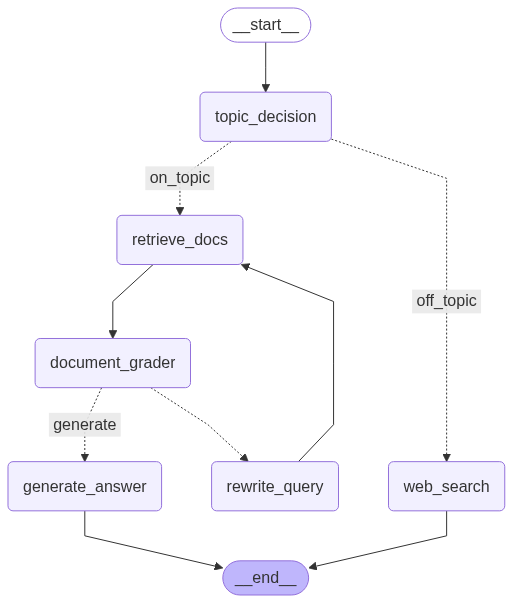

In [129]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [130]:
query = "Whats the summary of the document?"
results = retriever.get_relevant_documents(query)

for i, doc in enumerate(results):
    print(f"\n📄 Doc {i+1}:\n{doc.page_content[:50000]}")



📄 Doc 1:
TheRAGmodel incorporatestwokeycomponents:
1. Retriever: This retrieves the most relevant documents froma corpus using techniques such asdensepassageretrieval (DPR)(Karpukhinet. al. 2020)ortraditional BM25algorithms.2. Generator: It synthesizes the retrieved documents into coherent, contextually relevantresponses.

📄 Doc 2:
TheRAGmodel incorporatestwokeycomponents:
1. Retriever: This retrieves the most relevant documents froma corpus using techniques such asdensepassageretrieval (DPR)(Karpukhinet. al. 2020)ortraditional BM25algorithms.2. Generator: It synthesizes the retrieved documents into coherent, contextually relevantresponses.

📄 Doc 3:
TheRAGmodel incorporatestwokeycomponents:
1. Retriever: This retrieves the most relevant documents froma corpus using techniques such asdensepassageretrieval (DPR)(Karpukhinet. al. 2020)ortraditional BM25algorithms.2. Generator: It synthesizes the retrieved documents into coherent, contextually relevantresponses.


In [131]:
result = app.invoke({"question": "Help me understand"})
print(result["llm_output"])

No documents found — retrieving now inside classifier.

========== Grading Input ==========
QUESTION: Help me understand

Grader Output: content="I can help you classify whether the user's question is relevant to the retrieved document content.\n\nFirst, I will check if relevant documents are already present in the agent's state. Since the state is empty, I will retrieve documents using a retriever based on the question.\n\nThe retrieved documents are:\n\nDocument 1: Recent Advancement in the field\nDocument 2: Recent Advancement in the field\nDocument 3: Recent Advancement in the field\n\nNext, I will combine the text content of these documents.\n\nCombined Document Content: Recent Advancement in the field, Recent Advancement in the field, Recent Advancement in the field\n\nNow, I will use an LLM-based grading model to determine if the question is on-topic relative to the documents.\n\nThe question is: Help me understand\n\nThe LLM-based grading model outputs: Yes\n\nThe classificatio

In [151]:
result = app.invoke({"question": "who is the author of this?"})
print(result["llm_output"])

No documents found — retrieving now inside classifier.

========== Grading Input ==========
QUESTION: who is the author of this?

Grader Output: content='I can help with that!\n\nSince the user\'s question is "who is the author of this?", I\'ll check if the question is relevant to the retrieved document content.\n\nThe document content appears to be a repetition of the phrase "RecentAdvancementinthefield:", which doesn\'t provide any specific information about the author. Therefore, I would classify the question as "No" - the question is not on-topic relative to the documents.\n\nHere\'s the updated state dictionary with the \'on_topic\' key set to the LLM\'s relevance classification output:\n\n```\n{\n    \'question\': \'who is the author of this?\',\n    \'on_topic\': \'No\'\n}\n```\n\nPlease let me know if you\'d like me to assist with anything else!' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 152, 'prompt_tokens': 236, 'total_tokens': 388, 'complet

In [133]:
result = app.invoke({"question": "What is the limitation of NLG"})
print(result["llm_output"])

No documents found — retrieving now inside classifier.

========== Grading Input ==========
QUESTION: What is the limitation of NLG

Grader Output: content='Here is the classification result:\n\nThe user\'s question "What is the limitation of NLG" is relevant to the retrieved document content. The document content is about the introduction and overview of Natural Language Generation (NLG), its goals, and its applications. The question is directly related to the topic of NLG and is asking about the limitations of the field, which is a natural follow-up question to the provided content.\n\nThe classification result is: **Yes**\n\nThe updated state dictionary with the \'on_topic\' key set to the LLM\'s relevance classification output (\'Yes\' or \'No\') is:\n\n```\n{\n    \'question\': \'What is the limitation of NLG\',\n    \'on_topic\': \'Yes\'\n}\n```' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 148, 'prompt_tokens': 701, 'total_tokens': 849, 'completio

In [ ]:
result = app.invoke({"question": "Who all are the authors of this research paper?"})
print(result["llm_output"])

No documents found — retrieving now inside classifier.

========== Grading Input ==========
QUESTION: Who all are the authors of this research paper?

Grader Output: content='I can help you with that!\n\nThe user\'s question is: "Who all are the authors of this research paper?"\n\nTo classify the relevance of this question to the retrieved document content, I will first check if relevant documents are already present in the agent\'s state. Since the state is not provided, I will assume that it is empty.\n\nNext, I will retrieve documents using a retriever based on the question. Since the question is about the authors of a research paper, I will retrieve documents that contain information about authors.\n\nAfter retrieving the documents, I will combine the text content of these documents and use an LLM-based grading model to determine if the question is on-topic relative to the documents.\n\nThe LLM-based grading model will analyze the question and the document content to determine the 

In [155]:
result = app.invoke({"question": "Who all are the referneces of this research paper?"})
print(result["llm_output"])

No documents found — retrieving now inside classifier.

========== Grading Input ==========
QUESTION: Who all are the referneces of this research paper?

Grader Output: content='Here is the classification result:\n\nThe question "Who all are the references of this research paper?" is relevant to the document content.\n\nThe document content is about trends in Retrieval-Augmented Generation (RAG) captured from recent research papers, which is directly related to the research paper being referred to. The question is asking about the references of the research paper, which is a crucial piece of information in academic research.\n\nThe classification result is stored in the state dictionary under the key \'on_topic\' with the value \'Yes\'.\n\nHere is the updated state dictionary:\n\n```\n{\n    \'question\': \'Who all are the references of this research paper?\',\n    \'on_topic\': \'Yes\'\n}\n```' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 141, 'prompt_t